# Data Understanding and Preparation 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from textblob import TextBlob
import yfinance as yf
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from sklearn.decomposition import LatentDirichletAllocation 

import pandas as pd  

# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('vader_lexicon') 



# loading data 
file_path = r"C:\Users\ethio\Desktop\Tenx.AIM2 -ET\Week1\Data\raw_analyst_ratings.csv"

df=pd.read_csv(file_path)
print(df.columns.tolist())
df.head()


['Unnamed: 0', 'headline', 'url', 'publisher', 'date', 'stock']


,Unnamed: 0,headline,url,publisher,date,stock
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A


The unnamed column doesn't contribute any useful information beyond the row count. Before removing it, let's review 
the last few rows of the dataset.

In [4]:
print (df.tail(1))

         Unnamed: 0                                           headline  \
1407327     1413848  China Zenix Auto International Opens For Tradi...   

                                                       url      publisher  \
1407327  https://www.benzinga.com/news/ipos/11/05/10789...  Allie Wickman   

                        date stock  
1407327  2011-05-12 00:00:00    ZX  


As observed, the unnamed column does not add value beyond indicating the number of rows and can therefore be considered redundant.

In [5]:

df = df.drop(columns=['Unnamed: 0'])
# Verify the DataFrame after dropping the column
print("\nUpdated column names in the dataset:")
print(df.columns.tolist())
print("\nFirst few rows of the updated dataset:")
df.head()


Updated column names in the dataset:
['headline', 'url', 'publisher', 'date', 'stock']

First few rows of the updated dataset:


,headline,url,publisher,date,stock
0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A
1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A
2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A
3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A
4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A


# Data Cleaning 
Address missing values, identify and remove duplicates, and verify that all text is properly formatted (e.g., dates are in the correct format)
As it can be seen from the table the data column is in "%Y-%m-%d %H:%M:%S" format, and also converting the headlines to lowercase

In [6]:
# Check for missing values in the dataset
print("Missing values in each column:")
print(df.isnull().sum())
# Identify duplicate rows
print("Number of duplicate rows:")
print(df.duplicated().sum())
# Remove duplicate rows
df = df.drop_duplicates()
print("Remove duplicate rows:")
print(df.duplicated().sum())
date_format = "%Y-%m-%d %H:%M:%S%z"  
df['date'] = pd.to_datetime(df['date'], format=date_format, errors='coerce')
# Convert all headlines to lowercase to ensure consistency, as variations in case (e.g., "U" vs. "u") can affect text analysis.

df['headline'] = df['headline'].str.lower()
date_format = "%Y-%m-%d %H:%M:%S%z"
df.head()

Missing values in each column:
headline     0
url          0
publisher    0
date         0
stock        0
dtype: int64
Number of duplicate rows:
1
Remove duplicate rows:
0


,headline,url,publisher,date,stock
0,stocks that hit 52-week highs on friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A
1,stocks that hit 52-week highs on wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A
2,71 biggest movers from friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A
3,46 stocks moving in friday's mid-day session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A
4,b of a securities maintains neutral on agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A


# Descriptive Statistics
 After data cleansing, better to perform descriptive statistics, such as analyzing headline lengths. 
 Then count the number of articles per publisher to identify the most active ones and examine
 publication dates to identify trends over time


In [7]:
df['headline_length'] = df['headline'].str.len()

# descriptive statistics for headline lengths
headline_length_D_stats = df['headline_length'].describe()
print("Descriptive statistics for headline lengths:")
print(headline_length_D_stats)


Descriptive statistics for headline lengths:
count    1.407327e+06
mean     7.312054e+01
std      4.073532e+01
min      3.000000e+00
25%      4.700000e+01
50%      6.400000e+01
75%      8.700000e+01
max      5.120000e+02
Name: headline_length, dtype: float64


In [8]:
# Count the number of articles per publisher
publisher_counts = df['publisher'].value_counts()
print("\nNumber of articles per publisher:")
print(publisher_counts)



Number of articles per publisher:
publisher
Paul Quintaro        228373
Lisa Levin           186978
Benzinga Newsdesk    150484
Charles Gross         96732
Monica Gerson         82380
                      ...  
MoneyGeek                 1
muathe                    1
Robert Morris             1
LeftCoastHedgie           1
Jeremie Capron            1
Name: count, Length: 1034, dtype: int64


In [9]:
# Count articles per day
df['date'] = pd.to_datetime(df['date'])
daily_counts = df['date'].dt.date.value_counts().sort_index()
print("\nDaily publication counts:")
print(daily_counts)

# Get the minimum and maximum dates
min_date = df['date'].min()
max_date = df['date'].max()

print(f"Minimum Date: {min_date}")
print(f"Maximum Date: {max_date}")



Daily publication counts:
date
2011-04-27      1
2011-04-28      2
2011-04-29      2
2011-04-30      1
2011-05-01      1
             ... 
2020-06-07     25
2020-06-08    765
2020-06-09    804
2020-06-10    806
2020-06-11    544
Name: count, Length: 2528, dtype: int64
Minimum Date: 2011-04-27 21:01:48-04:00
Maximum Date: 2020-06-11 17:12:35-04:00



To analyze trends over time in publication dates, including increased news frequency on specific days or during particular events, we should plot the number of publications we can observe and understand the overall trends more effectively. Additionally, marking major events in the plots will help highlight significant changes in publication frequency

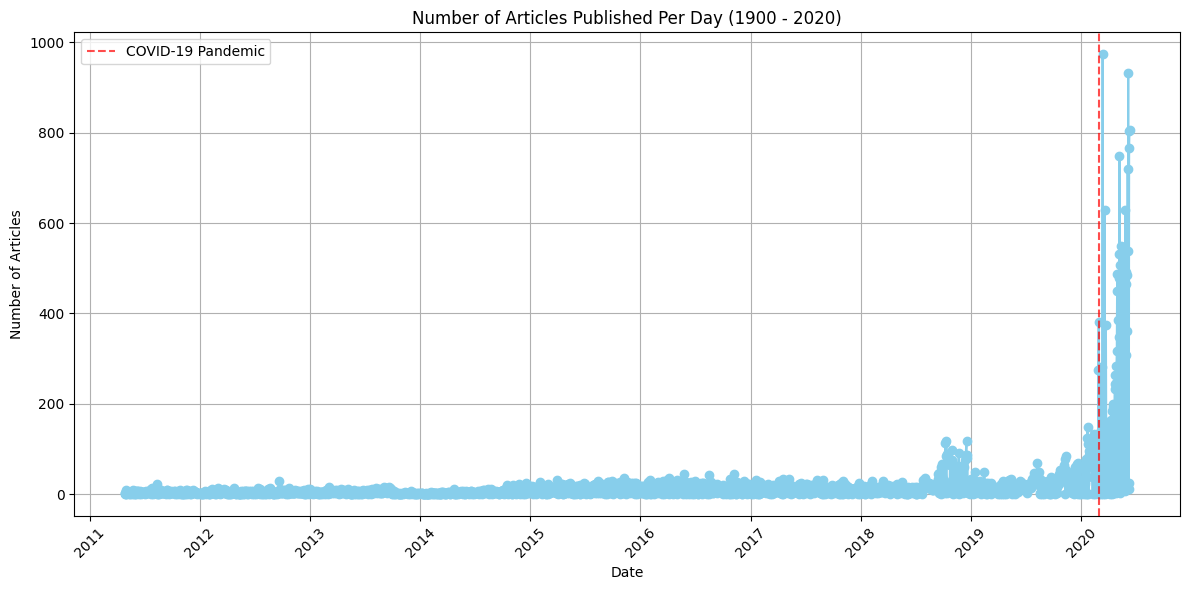

In [10]:
# Filter dates between 2011 and 2020
df = df[(df['date'] >= '2011-04-27') & (df['date'] <= '2020-06-11')]

# Extract date components
df['date'] = df['date'].dt.date
#%Y-%m-%d %H:%M:%S%z
# Count the number of articles published per day
date_format = "%Y-%m-%d %H:%M:%S"
df['date'] = pd.to_datetime(df['date'], format=date_format, errors='coerce')

# Group by date and count the number of articles
articles_per_day = df.groupby('date').size()

# Define major events
major_events = {
    'COVID-19 Pandemic': pd.Timestamp('2020-03-01'), 
}

# Plot the number of articles published per day
plt.figure(figsize=(12, 6))
plt.plot(articles_per_day.index, articles_per_day.values, marker='o', color='skyblue')
plt.title('Number of Articles Published Per Day (1900 - 2020)')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.grid(True)

# Add vertical lines for major events
for event, date in major_events.items():
    if date in articles_per_day.index:
        plt.axvline(date, color='red', linestyle='--', alpha=0.7, label=event)

# Add legend and format x-axis labels
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()

# Print the first few rows of the DataFrame
#df.head()

As it can be seen on the graph their is a significant increase in publication on the year 2020 this might be because of COVID 19 out brake

# Text Analysis (Sentiment analysis & Topic Modeling):

To perform sentiment analysis on headlines. we can use pre-built libraries like VADER,and Textblob. 


sentiment_category
Neutral     26240
Positive    16078
Negative    13125
Name: count, dtype: int64


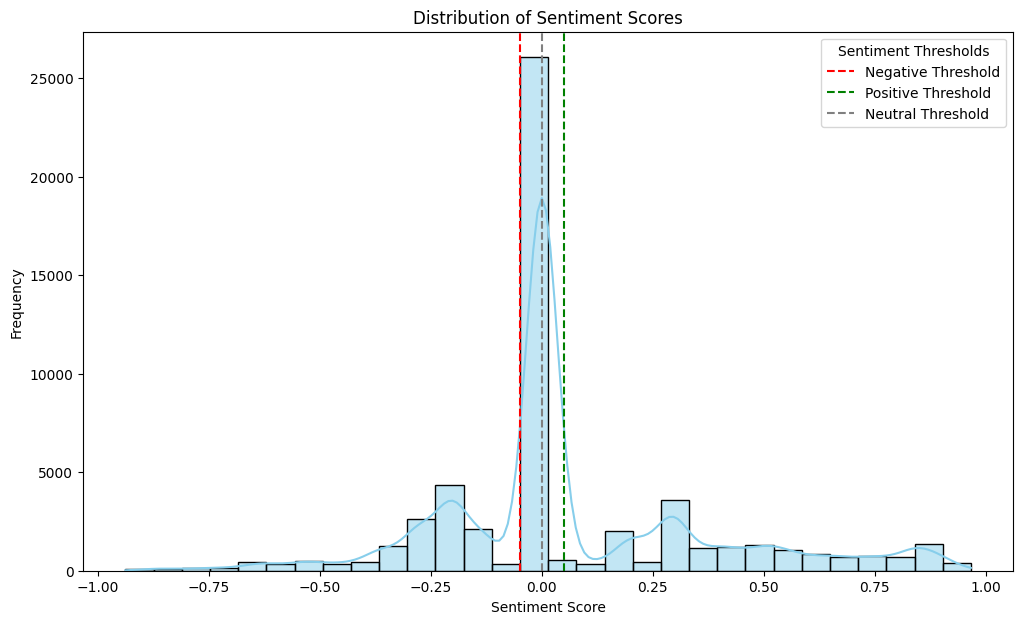

In [11]:
# Sentiment Analysis
stop_words = set(stopwords.words('english'))

# Initialize VADER sentiment analyzer
sid = SentimentIntensityAnalyzer()

def analyze_sentiment(text):
    sentiment_scores = sid.polarity_scores(text)
    compound_score = sentiment_scores['compound']
    return compound_score

df['sentiment'] = df['headline'].apply(analyze_sentiment)
positive_threshold = 0.05
negative_threshold = -0.05

# Categorize sentiment
def categorize_sentiment(score):
    if score >= positive_threshold:
        return 'Positive'
    elif score <= negative_threshold:
        return 'Negative'
    else:
        return 'Neutral'
df['sentiment_category'] = df['sentiment'].apply(categorize_sentiment)

# Count the number of occurrences in each sentiment category
sentiment_counts = df['sentiment_category'].value_counts()

print(sentiment_counts)   
# Plotting the distribution of sentiment scores
plt.figure(figsize=(12, 7))
sns.histplot(df['sentiment'], bins=30, kde=True, color='skyblue')

# Adding vertical lines for sentiment boundaries
plt.axvline(x=-0.05, color='red', linestyle='--', label='Negative Threshold')
plt.axvline(x=0.05, color='green', linestyle='--', label='Positive Threshold')
plt.axvline(x=0, color='gray', linestyle='--', label='Neutral Threshold')

plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.legend(title='Sentiment Thresholds')
plt.show()

The sentiment analysis plot displays the sentiment scores on the x-axis and their frequency on the y-axis. Data points below the red threshold are classified as negative sentiment, while those above the green threshold are categorized as positive sentiment. The analysis reveals that most headlines fall into the neutral sentiment category. When comparing negative and positive sentiments, positive sentiments are more prevalent than negative ones.

To identify common keywords or phrases, potentially extracting topics or significant events (like "FDA approval", "price target", etc.). First we have to preprocess the text data then extract keywords or phrases , finally " Topic Modeling" (finding significant topics in the data)

In [12]:
def preprocess_text(text):
    
    text = re.sub(r'\W+', ' ', text)
    text = text.lower()
    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words]) # the, and etc no impact on the sentiment 
    return text

df['processed_headline'] = df['headline'].apply(preprocess_text)

# Keyword Extraction using TF-IDF

tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=1000, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(df['processed_headline'])

# Extract top keywords per document
def get_top_keywords(tfidf_matrix, feature_names, top_n=5):
    top_keywords = []
    for i in range(tfidf_matrix.shape[0]):
        sorted_indices = tfidf_matrix[i].toarray()[0].argsort()[::-1]
        top_keywords.append([feature_names[j] for j in sorted_indices[:top_n]])
    return top_keywords

feature_names = tfidf_vectorizer.get_feature_names_out()
df['top_keywords'] = get_top_keywords(tfidf_matrix, feature_names)


Topic Modeling 

In [13]:
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(tfidf_matrix)

def display_topics(model, feature_names, no_top_words):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        top_features = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
        topics.append(" ".join(top_features))
    return topics

no_top_words = 10
df['topic'] = lda.transform(tfidf_matrix).argmax(axis=1)
topics = display_topics(lda, feature_names, no_top_words)

# Display the DataFrame with sentiment, top keywords, and topics
df.head()

,headline,url,publisher,date,stock,headline_length,sentiment,sentiment_category,processed_headline,top_keywords,topic
0,stocks that hit 52-week highs on friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05,A,39,0.000,Neutral,stocks hit 52 week highs friday,"[highs, friday, hit, 52, week]",2
1,stocks that hit 52-week highs on wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03,A,42,0.000,Neutral,stocks hit 52 week highs wednesday,"[wednesday, highs, hit, 52, week]",2
2,71 biggest movers from friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26,A,29,0.000,Neutral,71 biggest movers friday,"[71, movers, biggest, friday, 00]",0
3,46 stocks moving in friday's mid-day session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22,A,44,0.000,Neutral,46 stocks moving friday mid day session,"[46, day, friday, moving, mid]",2
4,b of a securities maintains neutral on agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22,A,87,0.296,Positive,b securities maintains neutral agilent technol...,"[88, securities, technologies, neutral, raises]",4


In [23]:

import os
import sys



current_dir = os.getcwd()
print(current_dir)

# Get the parent directory
parent_dir = os.path.dirname(current_dir)
print(parent_dir)

# Insert the path to the parent directory
sys.path.insert(0, parent_dir)


c:\Users\ethio\Desktop\Tenx.AIM2 -ET\Week1\Et.Task.W1\W1.FinNews-StockPrice-Integration\notebooks
c:\Users\ethio\Desktop\Tenx.AIM2 -ET\Week1\Et.Task.W1\W1.FinNews-StockPrice-Integration


In [25]:
from scripts.text_analysis import TextAnalysis


ModuleNotFoundError: No module named 'scripts.text_analysis'